In [33]:
"""install the necessary packages"""
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import numpy as np
#!conda install -c conda-forge geopy --yes
pd.set_option("display.precision", 3)
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.pyplot import cm
mpl.style.use('seaborn-poster')
import seaborn as sns

# Obtaining house price data
**We have previously obtained the house transaction data from the UK Land Registry as a csv - lets import it here and explore a bit**

In [2]:
data='House_price_data.csv'
df = pd.read_csv(data)
df.head()

,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,Unnamed: 16,Unnamed: 17
0,7C2D0700-8627-4963-E053-6B04A8C07B97,460000,19/11/2018,OX1 1JS,T,N,F,NaN,7,WOODBINE PLACE,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
1,919FEC05-A036-9A90-E053-6C04A8C0A300,432000,01/08/2019,OX1 1RP,T,N,F,NaN,5,BLACKFRIARS ROAD,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
2,773788C3-0BFB-2CE4-E053-6C04A8C05E57,435000,03/08/2018,OX1 1SU,T,N,F,NaN,66,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
3,75050A85-8A51-9A88-E053-6B04A8C02390,680000,24/08/2018,OX1 1SU,T,N,F,NaN,74,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
4,75050A85-8A53-9A88-E053-6B04A8C02390,485000,27/07/2018,OX1 1SU,T,N,F,NaN,78,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN


Let's tidy this up a bit - we will first remove the columns we are not interested, remove missing data and then make sure that they are all the correct data type

In [3]:
df = df.drop(['unique_id','saon','paon','locality','transaction_category','linked_data_uri','Unnamed: 16','Unnamed: 17'],axis=1) #removes columns we are not interested in
df = df.dropna(axis=0,subset=['price_paid','postcode']) #remove blank values for price and postcode (our key data)
print (df.shape)
df.tail()

(140969, 10)


,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county
140979,230000,23/11/2018,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140980,190000,25/01/2019,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140981,150000,16/05/2019,L9 9HZ,S,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140982,145000,20/09/2019,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140983,144000,11/05/2018,L9 9JA,S,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE


In [4]:
df.dtypes

price_paid        int64
deed_date        object
postcode         object
property_type    object
new_build        object
estate_type      object
street           object
town             object
district         object
county           object
dtype: object

In [5]:
df[["deed_date"]] = df[["deed_date"]].astype("datetime64[ns]") #convert date to correct format
df.dtypes

price_paid                int64
deed_date        datetime64[ns]
postcode                 object
property_type            object
new_build                object
estate_type              object
street                   object
town                     object
district                 object
county                   object
dtype: object

In [6]:
df.town.unique()

array(['OXFORD', 'LONDON', 'MANCHESTER', 'MILTON KEYNES',
       'NEWCASTLE UPON TYNE', 'NEWCASTLE', 'NEWCASTLE EMLYN', 'YORK',
       'BIRMINGHAM', 'BRISTOL', 'CARDIFF', 'LEEDS', 'LIVERPOOL'],
      dtype=object)

We can see that the search for 'Newcastle' found 2 additional towns which share a name with the town we are interested in (Newcastle upon Tyne), so let's get rid of those too.

In [7]:
df = df[df.town != 'NEWCASTLE']
df = df[df.town != 'NEWCASTLE EMLYN']
df.shape

(138755, 10)

In [8]:
df.describe(include='all')

,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county
count,1.388e+05,138755,138755,138755,138755,138755,138417,138755,138755,138755
unique,NaN,623,69796,4,2,1,35987,11,83,32
top,NaN,2019-06-28 00:00:00,NE13 9EG,T,N,F,CHURCH ROAD,LONDON,LEEDS,GREATER LONDON
freq,NaN,1514,65,64096,126865,138755,287,29319,14925,29290
first,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.114e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.136e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.730e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we want to generate a new column that contains only the first part of each postcode, e.g. OX1

In [9]:
df["postcode_group"]=df["postcode"].str.slice(stop=-4) #as the first part of the postcode is of variable length, we are removing the last 4 characters (i.e. 3 characters and the space)
df.head()

,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county,postcode_group
0,460000,2018-11-19,OX1 1JS,T,N,F,WOODBINE PLACE,OXFORD,OXFORD,OXFORDSHIRE,OX1
1,432000,2019-01-08,OX1 1RP,T,N,F,BLACKFRIARS ROAD,OXFORD,OXFORD,OXFORDSHIRE,OX1
2,435000,2018-03-08,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1
3,680000,2018-08-24,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1
4,485000,2018-07-27,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1


Let's also divide the price_paid column by 1000 to make it a little easier to understand

In [10]:
df['price_paid'] = df['price_paid']/1000
df.head()

,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county,postcode_group
0,460.0,2018-11-19,OX1 1JS,T,N,F,WOODBINE PLACE,OXFORD,OXFORD,OXFORDSHIRE,OX1
1,432.0,2019-01-08,OX1 1RP,T,N,F,BLACKFRIARS ROAD,OXFORD,OXFORD,OXFORDSHIRE,OX1
2,435.0,2018-03-08,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1
3,680.0,2018-08-24,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1
4,485.0,2018-07-27,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1


We have imported data from 1 January 2018 to the present day. We should examine the data to check if there have been any major variations in house price over the period we are looking at

In [11]:
df_time = df.sort_values(['deed_date'])
df_time = df_time.drop(['postcode','property_type','new_build','estate_type','street','district','county'],axis=1)
print(df_time.shape)
df_time.head()

(138755, 4)


,price_paid,deed_date,town,postcode_group
94374,239.995,2018-01-01,BRISTOL,BS30
134737,221.000,2018-01-01,LIVERPOOL,L25
34680,395.000,2018-01-01,MANCHESTER,M21
54633,234.950,2018-01-02,NEWCASTLE UPON TYNE,NE27
25885,715.000,2018-01-02,LONDON,SW18


Now, let's add a moving average column, over 30 day periods, and remove the entries at the beginning and end

In [12]:
df_ma = df_time.copy()
df_ma.set_index('deed_date', inplace = True)
df_ma['MA'] = df_ma.price_paid.rolling('30d').mean()
df_ma = df_ma.dropna(axis=0,subset=['MA'])
# print(df_ma.dtypes)
df_ma.head()

,price_paid,town,postcode_group,MA
deed_date,,,,
2018-01-01,239.995,BRISTOL,BS30,239.995
2018-01-01,221.000,LIVERPOOL,L25,230.498
2018-01-01,395.000,MANCHESTER,M21,285.332
2018-01-02,234.950,NEWCASTLE UPON TYNE,NE27,272.736
2018-01-02,715.000,LONDON,SW18,361.189


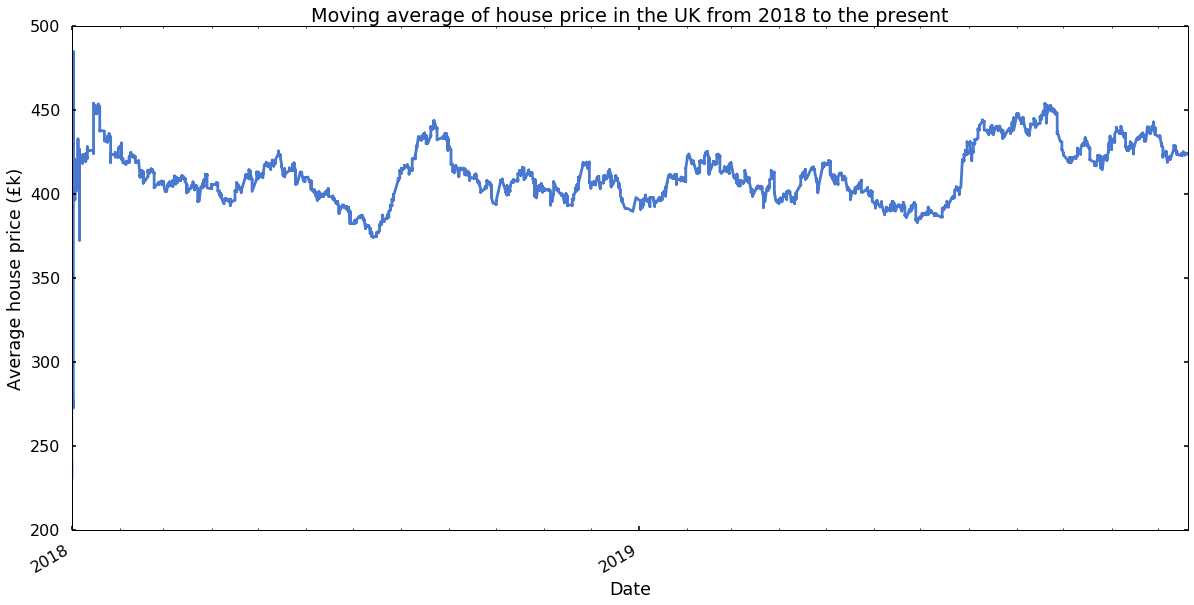

In [26]:
years = mdates.YearLocator()   # setting up dates as axis
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ma.index.values,df_ma['MA'])
ax.set(xlabel='Date',
       ylabel='Average house price (£k)',
       title='Moving average of house price in the UK from 2018 to the present',
       ylim=(200,500)
      )

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

fig.autofmt_xdate()

# fig.savefig("Figure1.png")
plt.show()

We can see a spike around August/September of 2019 but otherwise the fluctuation doesn't seem to be that large.  Let's compare our cities over this time.

In [40]:
cities = df_time.town.unique() #find unique values for towns
cities = sorted(cities)
string_a = 'df_'
citiesdfs = [string_a+x for x in cities]  #generates names for dfs for each city
colour = ['navy','cadetblue','blue','gray','coral','brown','deeppink','darkviolet','black','slateblue','green'] #define a list of 11 colours to differentiate the cities (matplotlib cycles normally)
print(cities)
print(citiesdfs)

['BIRMINGHAM', 'BRISTOL', 'CARDIFF', 'LEEDS', 'LIVERPOOL', 'LONDON', 'MANCHESTER', 'MILTON KEYNES', 'NEWCASTLE UPON TYNE', 'OXFORD', 'YORK']
['df_BIRMINGHAM', 'df_BRISTOL', 'df_CARDIFF', 'df_LEEDS', 'df_LIVERPOOL', 'df_LONDON', 'df_MANCHESTER', 'df_MILTON KEYNES', 'df_NEWCASTLE UPON TYNE', 'df_OXFORD', 'df_YORK']


C:\Users\Jacob\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


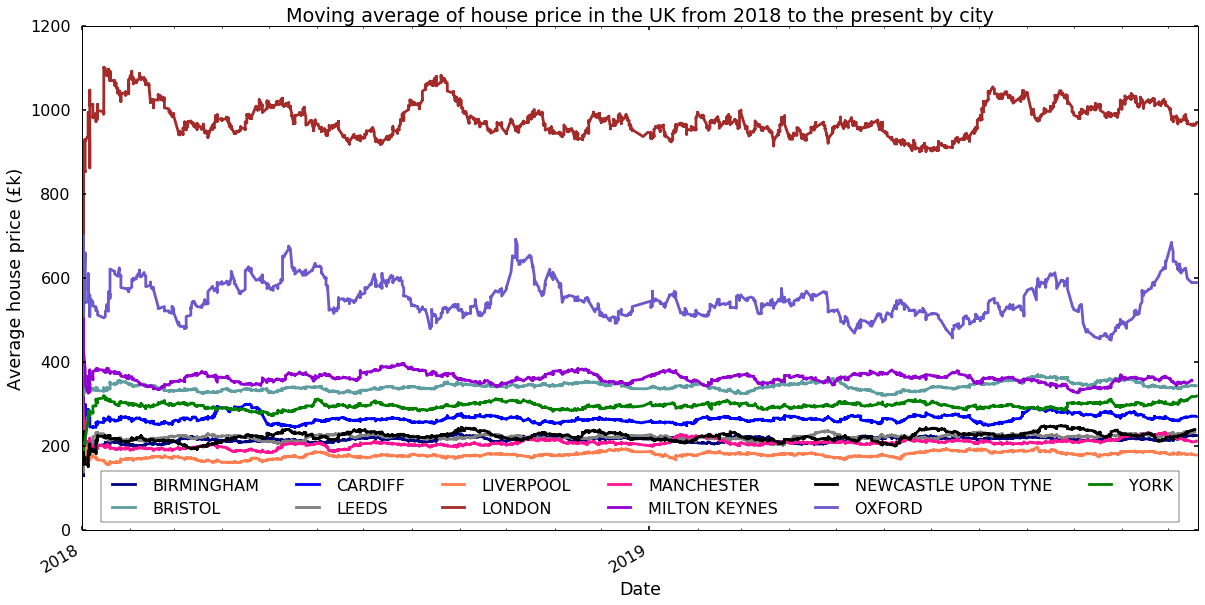

In [41]:
fig2, ax2 = plt.subplots(figsize=(20,10))
for i,j,c in zip(citiesdfs,cities,colour):
    i = df_time.loc[df_time['town'] == j]
    i.set_index('deed_date', inplace = True)
    i['MA'] = i.price_paid.rolling('30d').mean() #find rolling average
    i = i.drop(['town','postcode_group','price_paid'],axis=1) # remove superfluous columns
    i = i.rename(columns={'MA':j})
    ax2.plot(i.index.values,i[j],label=j,color=c)
#     print(i.head())
#     print()

ax2.set(xlabel='Date',
       ylabel='Average house price (£k)',
       title='Moving average of house price in the UK from 2018 to the present by city',
       ylim=(0,1200)
      )

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(years_fmt)
ax2.xaxis.set_minor_locator(months)


fig2.autofmt_xdate()
plt.legend(ncol=6,
           loc='lower center',
#            fontsize='medium'
          )
# fig.savefig("Figure1.png")
plt.show()

So, again we see that prices are relatively stable over this period, and we get a sense of the price differential between cities. London is unsurprisingly the most expensive, with an average price hovering about £1,000,000, while places like Liverpool, Manchester and Newcastle hover around the £200,000 mark

Initially let's focus on overall average price and average price for different property types

In [ ]:
price = df.drop(['deed_date','postcode','new_build','estate_type','street','town','district','county'],axis=1)
price_av = price.groupby(['postcode_group']).mean() #gives average house price over the last 2 years in each postcode group
pricetype = price.groupby(['postcode_group','property_type']).mean() #gives average of each type of property (Terrace, Detached, Semi-Detached, Flat)
                                                                    # we will use this later
price_av.head()